# DAML 09 - SVMs in Action

Michal Grochmal <michal.grochmal@city.ac.uk>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import randint as sp_randint  # talk about this one
from scipy.stats import uniform

In [2]:
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Olivetti Faces

We will first attempt to classify a dataset in which faces are well centered in the images.
The Olivetti faces is a set of 400 images of faces, 10 faces per person.
It is a very clean dataset: the faces are well centered and the *support* of each class
(number of instances) is the same across all classes.

In [3]:
ofaces = fetch_olivetti_faces()
print(ofaces.DESCR)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



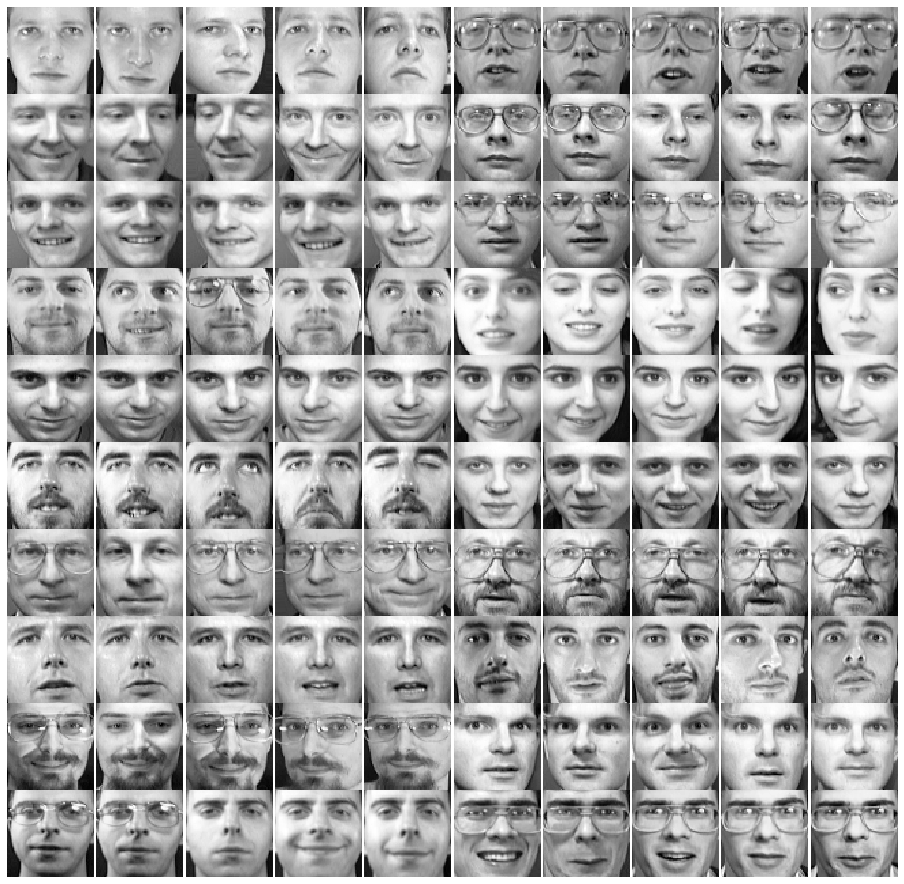

In [4]:
fig, axes = plt.subplots(10, 10, figsize=(16, 16), subplot_kw={'xticks':[], 'yticks':[]})
fig.subplots_adjust(hspace=0, wspace=0)
for i, ax in enumerate(axes.flat):
    ax.imshow(ofaces.images[i*2], cmap='binary_r')

In [5]:
model = make_pipeline(PCA(n_components=200, svd_solver='randomized'), SVC())
# we need to force a shuffle for this dataset
strategy = KFold(n_splits=5, shuffle=True)
# can be dist or list of dicts
param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [1, 10, 100, 1000, 10000]},
    {'svc__kernel': ['rbf'], 'svc__C': [1, 10, 1000, 10000], 'svc__gamma': [0.001, 0.1, 1.0, 10.0]}
]
grid = GridSearchCV(model, param_grid, cv=strategy)
# this will take a while
grid.fit(ofaces.data, ofaces.target)
grid.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [6]:
grid.best_score_

0.94999999999999996

The `C` parameter of an SVM is its tolerance to data points inside the support vectors.
A smaller `C` results in a model with better generalization (better at classifying unknown
data) because it is less sensitive to noise in the data.

That grid search took a while, there is a way of performing a slightly faster search
by limiting the number of iterations whilst trying some numbers at random.

In [7]:
model = make_pipeline(PCA(n_components=200, svd_solver='randomized'), SVC())
strategy = KFold(n_splits=5, shuffle=True)
# cannot provide a list
param_dist = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': sp_randint(1, 100000),
    'svc__gamma': uniform(0.001, 10.0)
}
search = RandomizedSearchCV(model, param_dist, cv=strategy, n_iter=20)
# this will take a while
search.fit(ofaces.data, ofaces.target)
search.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)), ('svc', SVC(C=73105, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.7409006441310548,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [8]:
search.best_score_

0.96250000000000002

### Multicalss SVMs

Have you noticed something strange?
I just told you that an SVM draws a line between two classes but we just
classified 40 different classes.  What magic is happening here?

In reality we have trained 780 different SVMs, one for each pair of classes
$(combination(40, 2) = 780)$.  An SVM is a **binary classifier**, i.e. it can
only classify between two classes, often called the *negative class* and the
*positive class*.  What the Support Vector Classifier (`SVC`) performs is a
technique called *One vs One* (OVO), in which it trains a classifier for each pair
of classes and then runs all the classifiers to perform the prediction.

One vs All (OVA) is another technique to make a binary classifier work on several
classes.  Whilst OVO trains a classifier for each pair of classes on subsets of data,
OVA trains a classifier for each class considering it as the positive class and all
other classes as the negative class.

OVO trains more classifiers but OVA trains all classifiers on the full dataset.
For SVMs OVO is faster because an SVM takes much longer to train when the amount
of data increases, i.e. training more small SVMs is faster than few big SVMs.

## Real Wold Problem

Classification issues on the Olivetti faces hard to visualize because out classes are just numbers.
Let's use the Labeled Faces in the Wild dataset again, since we can recognize some of the people
in there by ourselves.

LFW is a much harder dataset: the faces are in different orientations and the support of distinct
classes vary considerably.  This is close to a real world problem, therefore let's treat it as such.
For a while we have been relying on cross-validation to check our models but for real world data,
where we expect to have new (previously unknown) data thrown at our classifier, this is not enough.
For this problem we will use three sets: **a training set, a validation set and a test set**.

In [9]:
faces = fetch_lfw_people(min_faces_per_person=50)
len(faces.data), faces.target_names

(1560,
 array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
        'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac',
        'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi',
        'Serena Williams', 'Tony Blair'],
       dtype='<U17'))

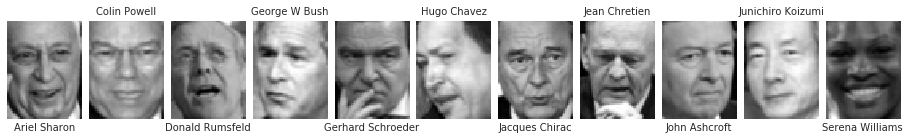

In [10]:
fig, axes = plt.subplots(1, 11, figsize=(16, 3), subplot_kw={'xticks':[], 'yticks':[]})
fig.subplots_adjust(hspace=0.1, wspace=0.1)
first_img = [np.argmax(faces.target == x) for x in list(range(len(faces.target_names)))]
for i, ax in enumerate(axes.flat):
    idx = first_img[i]
    ax.imshow(faces.data[idx].reshape(62, 47), cmap='binary_r')
    if i % 2:
        ax.set_title(faces.target_names[i], fontsize=10)
    else:
        ax.set_xlabel(faces.target_names[i], fontsize=10)

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(faces.data, faces.target, test_size=0.2)

In [12]:
model = make_pipeline(PCA(n_components=200, svd_solver='randomized'), SVC())
param_dist = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': sp_randint(1, 100000),
    'svc__gamma': uniform(0.001, 10.0)
}
search = RandomizedSearchCV(model, param_dist, cv=5, n_iter=20)
# this will take a while
search.fit(xtrain, ytrain)
search.best_estimator_

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)), ('svc', SVC(C=94655, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=7.0317158920315199,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [13]:
search.best_score_

0.78205128205128205

In [14]:
yfit = search.best_estimator_.predict(xtest)
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.61      0.55      0.58        20
     Colin Powell       0.88      0.83      0.85        53
  Donald Rumsfeld       0.64      0.84      0.72        25
    George W Bush       0.86      0.85      0.86        98
Gerhard Schroeder       0.69      0.91      0.78        22
      Hugo Chavez       1.00      0.88      0.93         8
   Jacques Chirac       0.88      0.54      0.67        13
    Jean Chretien       0.77      0.83      0.80        12
    John Ashcroft       0.80      0.75      0.77        16
Junichiro Koizumi       1.00      1.00      1.00         9
  Serena Williams       0.86      0.75      0.80         8
       Tony Blair       0.78      0.75      0.76        28

      avg / total       0.81      0.80      0.80       312



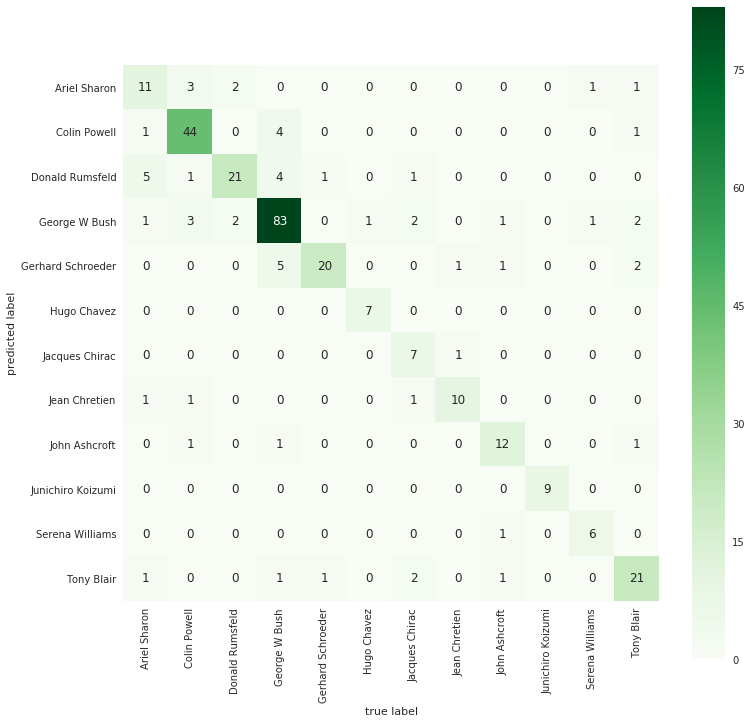

In [15]:
m = confusion_matrix(ytest, yfit)
fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(m.T, square=True, annot=True, fmt='d', cmap='Greens',
                 xticklabels=faces.target_names, yticklabels=faces.target_names)
ax.set(xlabel='true label', ylabel='predicted label');

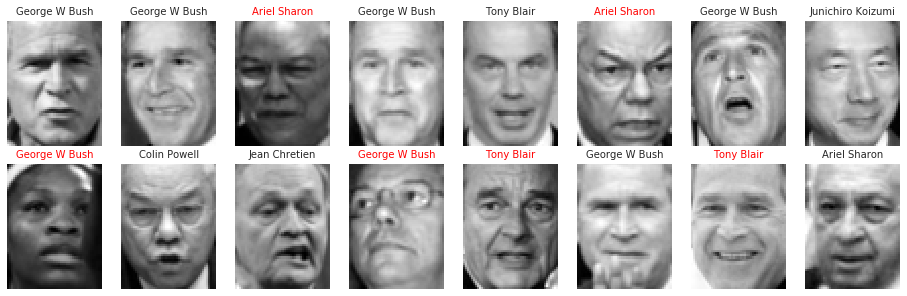

In [16]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5), subplot_kw={'xticks':[], 'yticks':[]})
fig.subplots_adjust(hspace=0.1, wspace=0.2)
correct = yfit == ytest
for i, ax in enumerate(axes.flat):
    ax.imshow(xtest[i].reshape(62, 47), cmap='binary_r')
    if correct[i]:
        ax.set_title(faces.target_names[ytest[i]], fontsize=10)
    else:
        ax.set_title(faces.target_names[yfit[i]], fontsize=10, color='red')